In [ ]:
# Carregar o dataset
dataset = pd.read_csv('diabetes_prediction_dataset.csv')
print(dataset['diabetes'].value_counts())

# knn(dataset)
# randomForestClassifier(dataset)
# mlpClassifier(dataset)
# logisticRegression(dataset)
# decisionTreeClassifier(dataset)
# Tempo total de execução = 13 min

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import RocCurveDisplay, precision_recall_curve, PrecisionRecallDisplay, confusion_matrix, ConfusionMatrixDisplay

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix

import pandas as pd
import matplotlib.pyplot as plt

def printMetrics(y_test, y_pred, X_test, model, best_params):
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    # y_score = model.predict_proba(X_test)[:, 1]
    
    if (best_params != None):
        print(f"Melhores Parametros: {best_params}\nAcurácia: {accuracy} \nRevocação: {recall} \nPrecisão: {precision} \nF1 score: {f1}")
    else:
        print(f"Acurácia: {accuracy} \nRevocação: {recall} \nPrecisão: {precision} \nF1 score: {f1}")

    roc_display = RocCurveDisplay.from_estimator(model, X_test, y_test)

    y_score = model.predict_proba(X_test)[:, 1]
    prec, recall, _ = precision_recall_curve(y_test, y_score, pos_label=model.classes_[1])
    pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()
    
    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_).plot()

    
def set(dataset):
    X = dataset.drop(columns=['diabetes'])
    y = dataset['diabetes']

    # Codifica as colunas 'gender', 'smoking_history'
    columns_to_encode = ['gender', 'smoking_history']
    X_encoded = pd.get_dummies(X, columns=columns_to_encode)
    
    # Realiza o underSample
    rus = RandomUnderSampler(random_state=1234)
    X_resampled, y_resampled = rus.fit_resample(X_encoded, y)

    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=1234)

    scaler = StandardScaler(with_mean=False)
    scaler.fit(X_train)

    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, y_train, X_test_scaled, y_test

# Classificação:
def mlpClassifier(dataset):
    print("-------------- MLP Classifier --------------")
    X_train, y_train, X_test, y_test = set(dataset)

    mlp = MLPClassifier(random_state=1234, max_iter=1000)
    parameters = {'alpha': [1e-1, 1e-2, 1e-3, 1e-4, 1e-5], 'momentum': [0.5, 0.9, 0.95, 0.99], 'hidden_layer_sizes': [(5,), (10,), (15,), (20,)]}

    gs = GridSearchCV(mlp, parameters)
    gs.fit(X_train, y_train.ravel())

    best_params = gs.best_params_

    best_mlp = MLPClassifier(alpha=best_params['alpha'], momentum=best_params['momentum'], hidden_layer_sizes=best_params['hidden_layer_sizes'], random_state=1234, max_iter=1000)
    best_mlp.fit(X_train, y_train.ravel())
    
    y_pred = best_mlp.predict(X_test)

    printMetrics(y_test, y_pred, X_test, best_mlp, best_params)

    # plt.plot(best_mlp.loss_curve_)

def knn(dataset):
    print("-------------- KNN --------------")
    X_train, y_train, X_test, y_test = set(dataset)

    knn = KNeighborsClassifier()
    parameters = {'n_neighbors': list(i for i in range(1, 52, 2))}

    gs = GridSearchCV(knn, parameters)
    gs.fit(X_train, y_train.ravel())

    best_params = gs.best_params_

    best_knn = KNeighborsClassifier(n_neighbors=best_params['n_neighbors'])
    best_knn.fit(X_train, y_train.ravel())
    
    y_pred = best_knn.predict(X_test)

    printMetrics(y_test, y_pred, X_test, best_knn, best_params)

    # val_plt = plt.subplot(2,3,1)
    # val_plt.plot(best_knn.loss_curve_)

def logisticRegression(dataset):
    print("-------------- Regressão Logística --------------")
    X_train, y_train, X_test, y_test = set(dataset)

    lr = LogisticRegression(max_iter=5000, random_state=1234, tol=1e-5)
    lr.fit(X_train, y_train.ravel())
    
    y_pred = lr.predict(X_test)

    printMetrics(y_test, y_pred, X_test, lr, None)

    # val_plt = plt.subplot(2,3,1)
    # val_plt.plot(lr.loss_curve_)

def decisionTreeClassifier(dataset):
    print("-------------- Árvore de Decisão --------------")
    X_train, y_train, X_test, y_test = set(dataset)

    dt = DecisionTreeClassifier()
    dt.fit(X_train, y_train)

    y_pred = dt.predict(X_test)

    printMetrics(y_test, y_pred, X_test, dt, None)

    # val_plt = plt.subplot(2,3,1)
    # val_plt.plot(dt.loss_curve_)

def randomForestClassifier(dataset):
    print("-------------- Random Forest --------------")
    X_train, y_train, X_test, y_test = set(dataset)

    rf = RandomForestClassifier()
    parameters = {'n_estimators': list(i for i in range(10, 201, 10)), 'max_depth': [4, 6, 8, 10, None]}

    gs = GridSearchCV(rf, parameters)
    gs.fit(X_train, y_train.ravel())

    best_params = gs.best_params_

    best_rf = RandomForestClassifier(n_estimators=best_params['n_estimators'], max_depth=best_params['max_depth'], random_state=1234)
    best_rf.fit(X_train, y_train.ravel())

    y_pred = best_rf.predict(X_test)
    
    printMetrics(y_test, y_pred, X_test, best_rf, best_params)

    # val_plt = plt.subplot(2,3,1)
    # val_plt.plot(best_knn.loss_curve_)


-------------- KNN --------------
Melhores Parametros: {'n_neighbors': 15}
Acurácia: 0.8823529411764706 
Revocação: 0.9034157832744405 
Precisão: 0.8666666666666667 
F1 score: 0.8846597462514417


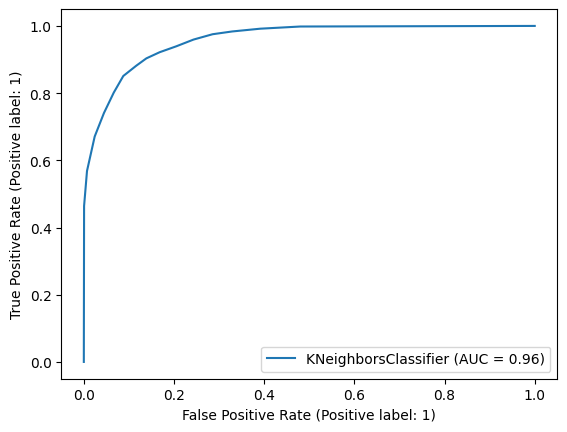

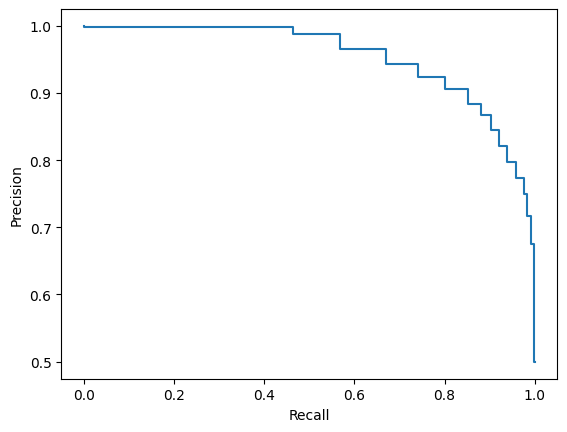

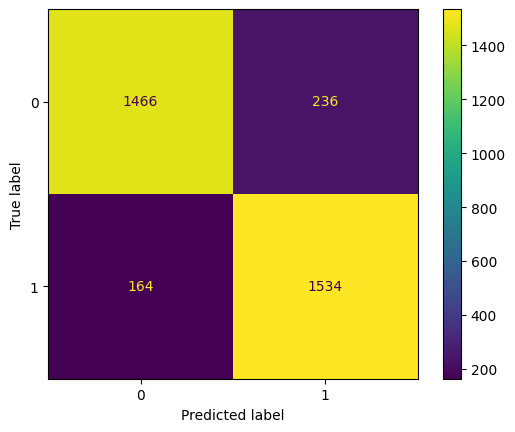

In [4]:
knn(dataset)

-------------- Random Forest --------------
Melhores Parametros: {'max_depth': 10, 'n_estimators': 60}
Acurácia: 0.9070588235294118 
Revocação: 0.9122497055359247 
Precisão: 0.9026806526806527 
F1 score: 0.9074399531341535


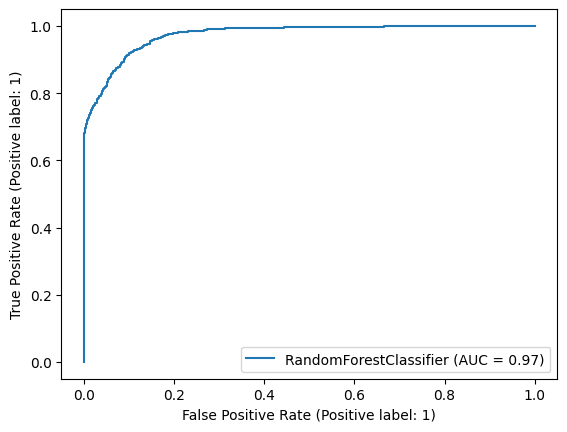

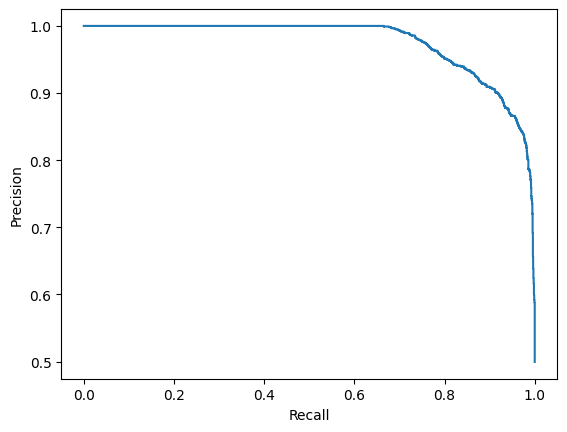

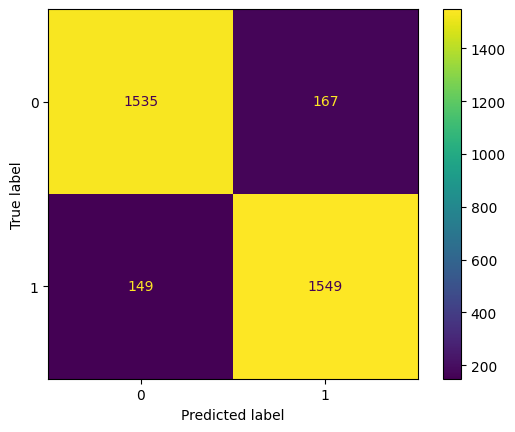

In [5]:
randomForestClassifier(dataset)

-------------- MLP Classifier --------------
Melhores Parametros: {'alpha': 0.0001, 'hidden_layer_sizes': (20,), 'momentum': 0.5}
Acurácia: 0.8811764705882353 
Revocação: 0.8769140164899882 
Precisão: 0.8842042755344418 
F1 score: 0.8805440567711413


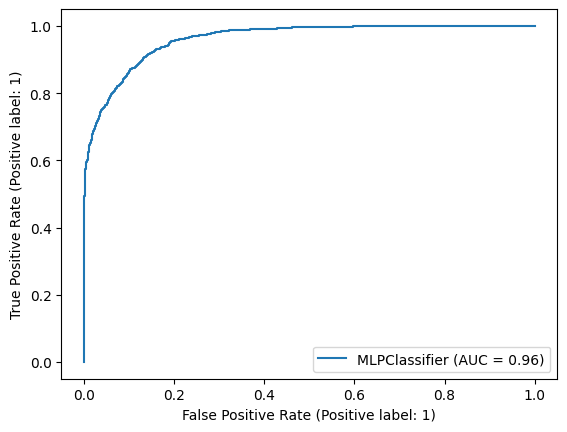

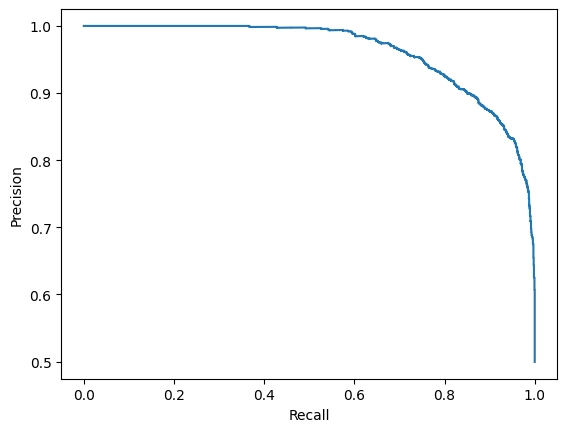

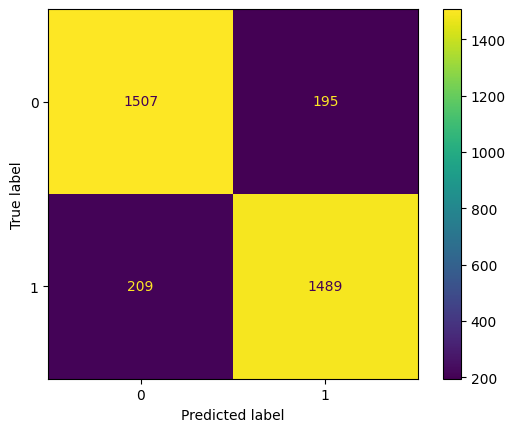

In [6]:
mlpClassifier(dataset)